# Experiments

The Mondrian Forest algorithm was compared with two classical Random Forest algorithms — Breiman RF and Extremely Randomized Forest:

- refitted on data of steps $[1, t]$ for each step $t$;
- refitted in a rolling-window $[t-h, t]$ with $h=1$ and $5$;
- with 20\% and 50\% of trees (oldest trees) refitted on all data at each step.

We implemented Mondrian Random Forest in Python and used the existing scikit-learn  implementations of Breiman RF (RandomForestClassifier) and Extremely Randomized Forest (ExtraTreesClassifier).

The goal of the experiments was to evaluate the predictive performance (measured as test accuracy) of online Random Forest algorithms as a function of (1) fraction of training data and (2) training time. The experiments were conducted in the following way:

- The training data was splitted into 10 mini-batches and iteratively fed to each algorithm.
- At each step the accuracy on test and train, and training time was evaluated.
- Each algorithm was evaluated 5 times with different random initialization, and the mean results were reported.

The hyperparameters setting:

- Each algorithm was evaluated with 10 and 100 trees.
- For Random Forest and Extremely Randomized Forest the used maximum depth is 3 (weak base learner), 10 (more complex base learner) and None (to compare with Mondrian trees with unlimited budget). 
- As there is no direct mapping of Mondrian Forest budget parameter to maximum depth, the unlimited budget was considered.
- Other parameters were set to their default values.

In [10]:
from experiments import run_all_methods_all_datasets

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading usps...
X_train.shape:	 (7291, 256)
y_train.shape:	 (7291,)
X_test.shape:	 (2007, 256)
y_test.shape:	 (2007,)
Running on usps...
	classical_full_data
	classical_window_1
	classical_window_3
	classical_window_5
	classical_increment_frac_0.2
	classical_increment_frac_0.5
	extratrees_full_data
	extratrees_increment_frac_0.2
	extratrees_increment_frac_0.5
	mondrian


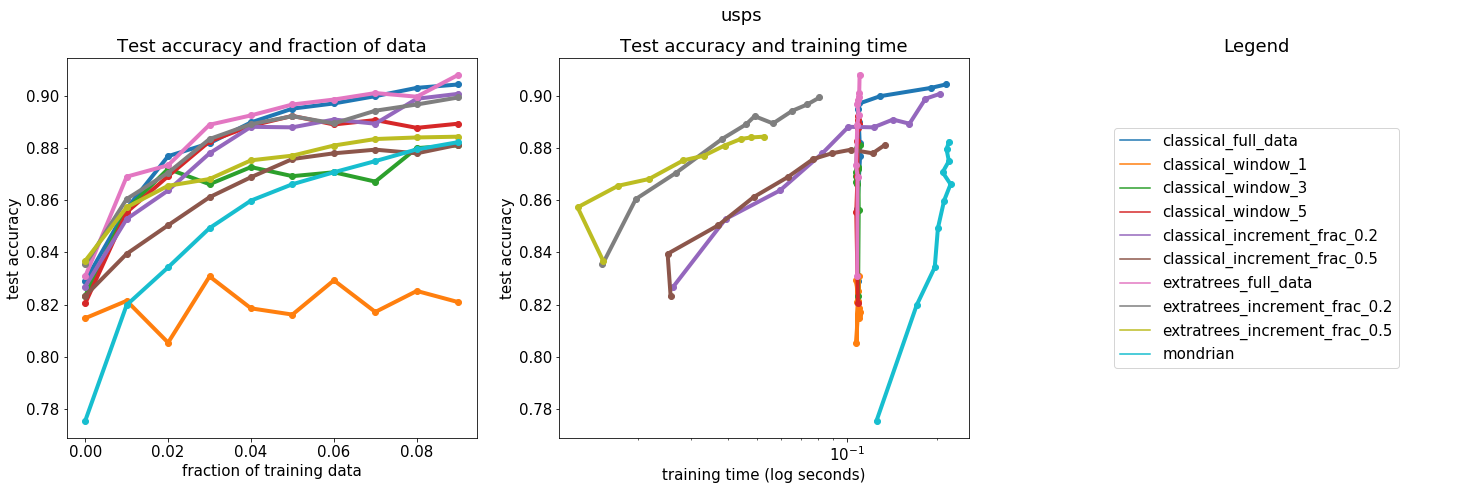

Loading letter...
X_train.shape:	 (15000, 16)
y_train.shape:	 (15000,)
X_test.shape:	 (5000, 16)
y_test.shape:	 (5000,)
Running on letter...
	classical_full_data


/Users/maria/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


	classical_window_1
	classical_window_3
	classical_window_5
	classical_increment_frac_0.2
	classical_increment_frac_0.5
	extratrees_full_data
	extratrees_increment_frac_0.2
	extratrees_increment_frac_0.5
	mondrian


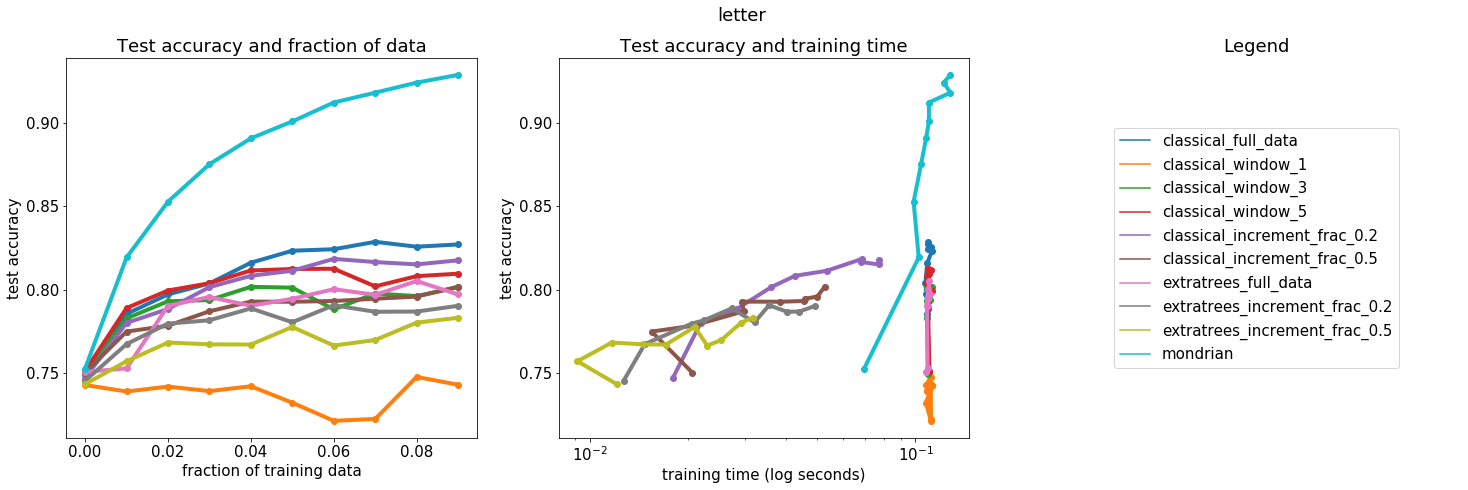

Loading satim...
X_train.shape:	 (4435, 36)
y_train.shape:	 (4435,)
X_test.shape:	 (2000, 36)
y_test.shape:	 (2000,)
Running on satim...
	classical_full_data


/Users/maria/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


	classical_window_1
	classical_window_3
	classical_window_5
	extratrees_full_data
	mondrian


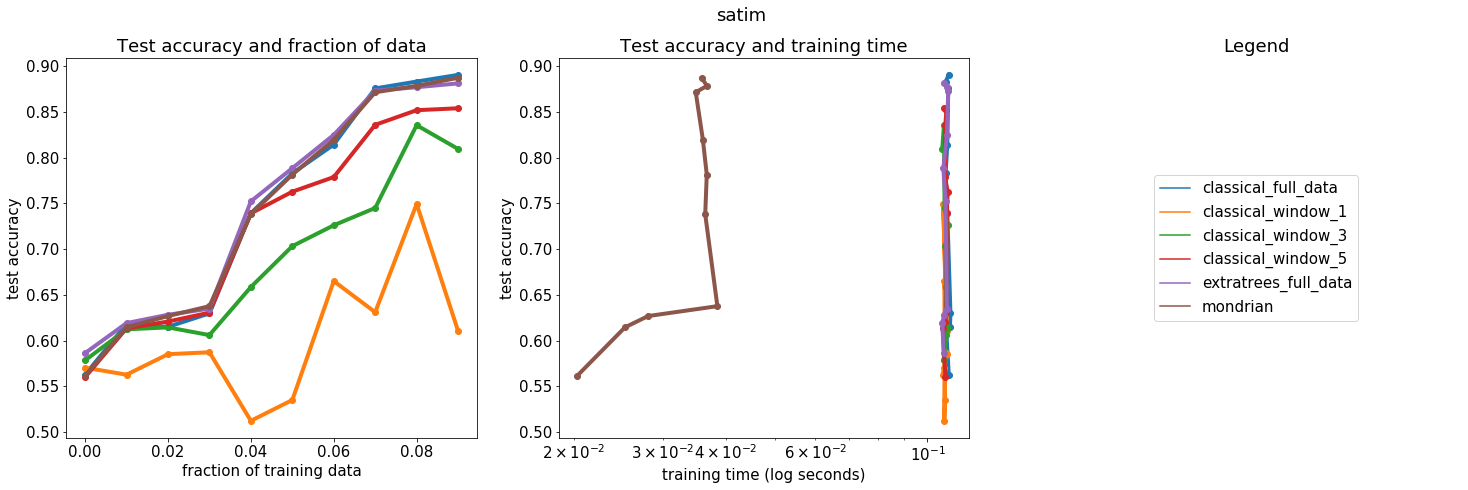

Loading dna...
X_train.shape:	 (1400, 180)
y_train.shape:	 (1400,)
X_test.shape:	 (1186, 180)
y_test.shape:	 (1186,)
Running on dna...
	classical_full_data
	classical_window_1
	classical_window_3
	classical_window_5
	classical_increment_frac_0.2
	classical_increment_frac_0.5
	extratrees_full_data
	extratrees_increment_frac_0.2
	extratrees_increment_frac_0.5
	mondrian


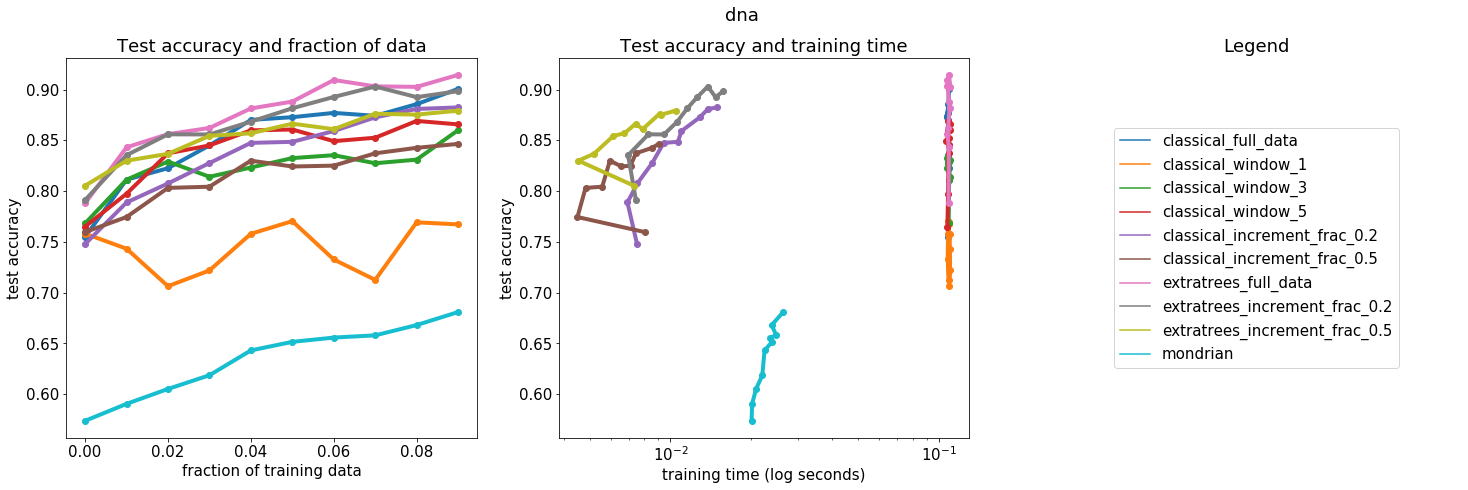

CPU times: user 2min 24s, sys: 11.9 s, total: 2min 36s
Wall time: 6min 37s


In [14]:
%%time

n_batches = 10
n_estimators = 10
max_depth = 10
n_iter = 5

run_all_methods_all_datasets(n_iter, n_batches, n_estimators, max_depth)

Loading usps...
X_train.shape:	 (7291, 256)
y_train.shape:	 (7291,)
X_test.shape:	 (2007, 256)
y_test.shape:	 (2007,)
Running on usps...
	classical_full_data
	classical_window_1
	classical_window_3
	classical_window_5
	classical_increment_frac_0.2
	classical_increment_frac_0.5
	extratrees_full_data
	extratrees_increment_frac_0.2
	extratrees_increment_frac_0.5
	mondrian


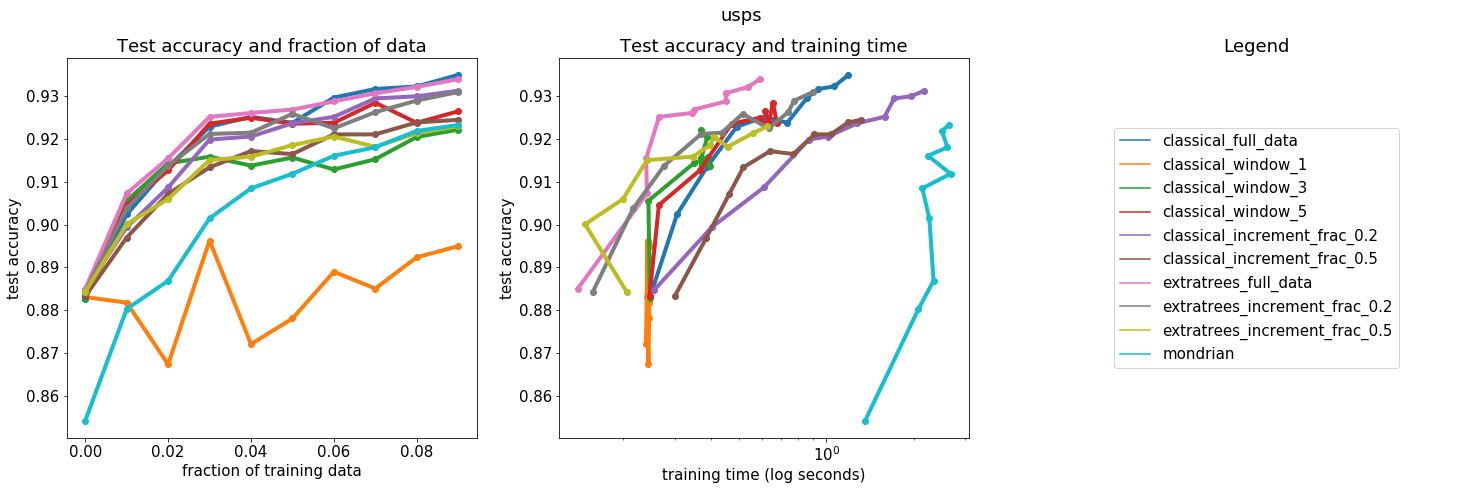

Loading letter...


/Users/maria/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


X_train.shape:	 (15000, 16)
y_train.shape:	 (15000,)
X_test.shape:	 (5000, 16)
y_test.shape:	 (5000,)
Running on letter...
	classical_full_data
	classical_window_1
	classical_window_3
	classical_window_5
	classical_increment_frac_0.2
	classical_increment_frac_0.5
	extratrees_full_data
	extratrees_increment_frac_0.2
	extratrees_increment_frac_0.5
	mondrian


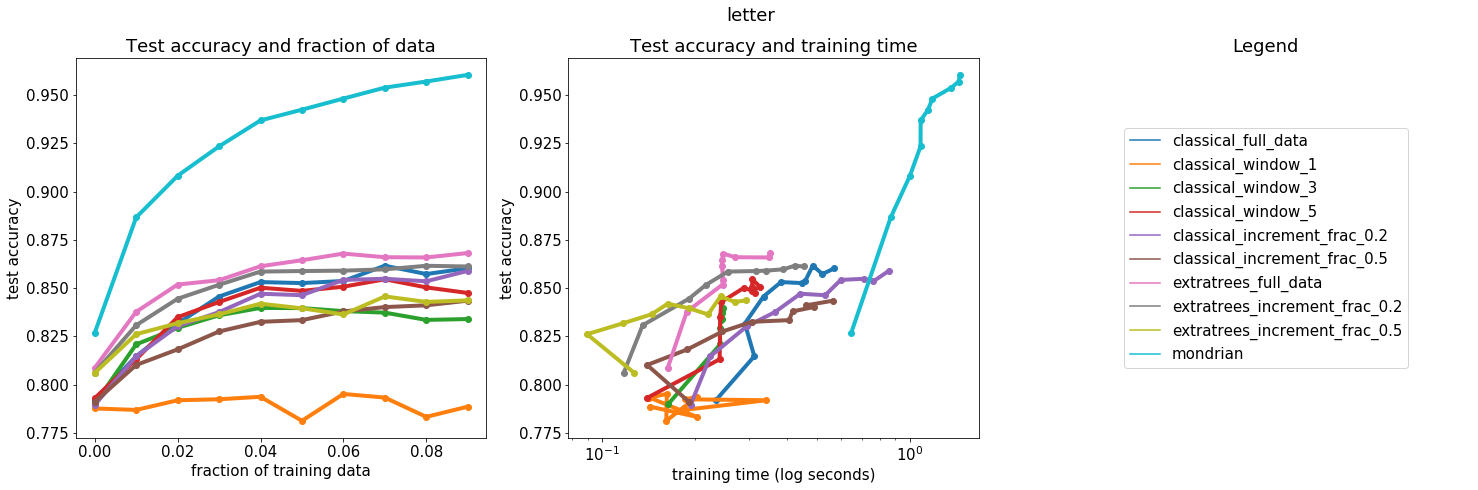

Loading satim...
X_train.shape:	 (4435, 36)
y_train.shape:	 (4435,)
X_test.shape:	 (2000, 36)
y_test.shape:	 (2000,)
Running on satim...
	classical_full_data


/Users/maria/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


	classical_window_1
	classical_window_3
	classical_window_5
	extratrees_full_data
	mondrian


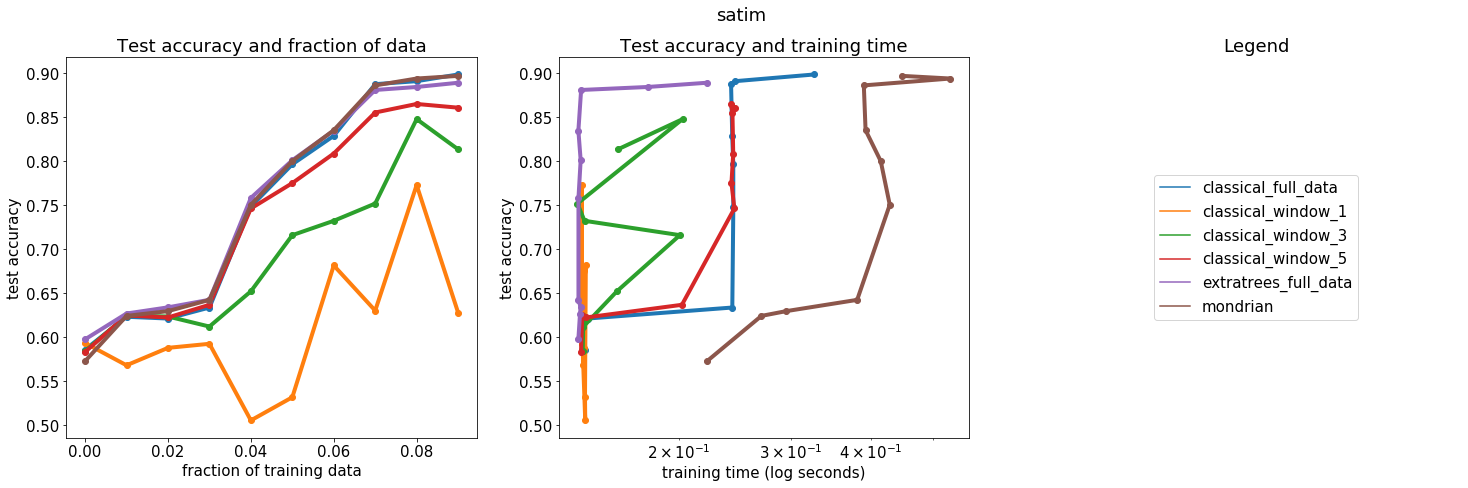

Loading dna...
X_train.shape:	 (1400, 180)
y_train.shape:	 (1400,)
X_test.shape:	 (1186, 180)
y_test.shape:	 (1186,)
Running on dna...
	classical_full_data
	classical_window_1
	classical_window_3
	classical_window_5
	classical_increment_frac_0.2
	classical_increment_frac_0.5
	extratrees_full_data
	extratrees_increment_frac_0.2
	extratrees_increment_frac_0.5
	mondrian


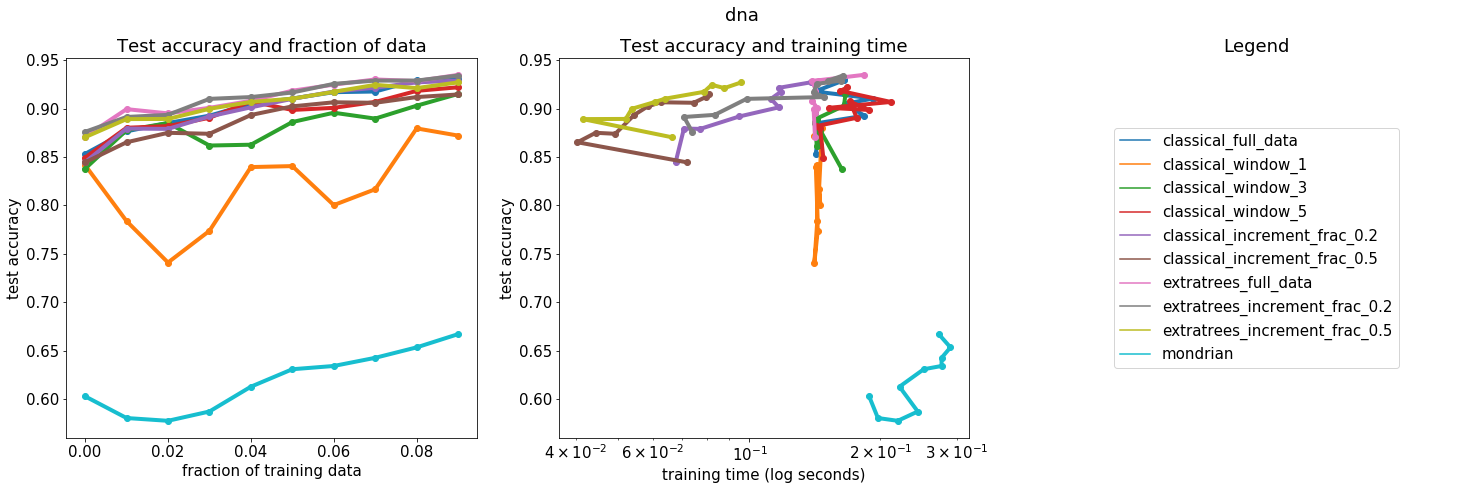

CPU times: user 22min 3s, sys: 1min 42s, total: 23min 46s
Wall time: 20min 26s


In [15]:
%%time

n_batches = 10
n_estimators = 100
max_depth = 10
n_iter = 5

run_all_methods_all_datasets(n_iter, n_batches, n_estimators, max_depth)

Loading usps...
X_train.shape:	 (7291, 256)
y_train.shape:	 (7291,)
X_test.shape:	 (2007, 256)
y_test.shape:	 (2007,)
Running on usps...
	classical_full_data
	classical_window_1
	classical_window_3
	classical_window_5
	classical_increment_frac_0.2
	classical_increment_frac_0.5
	extratrees_full_data
	extratrees_increment_frac_0.2
	extratrees_increment_frac_0.5
	mondrian


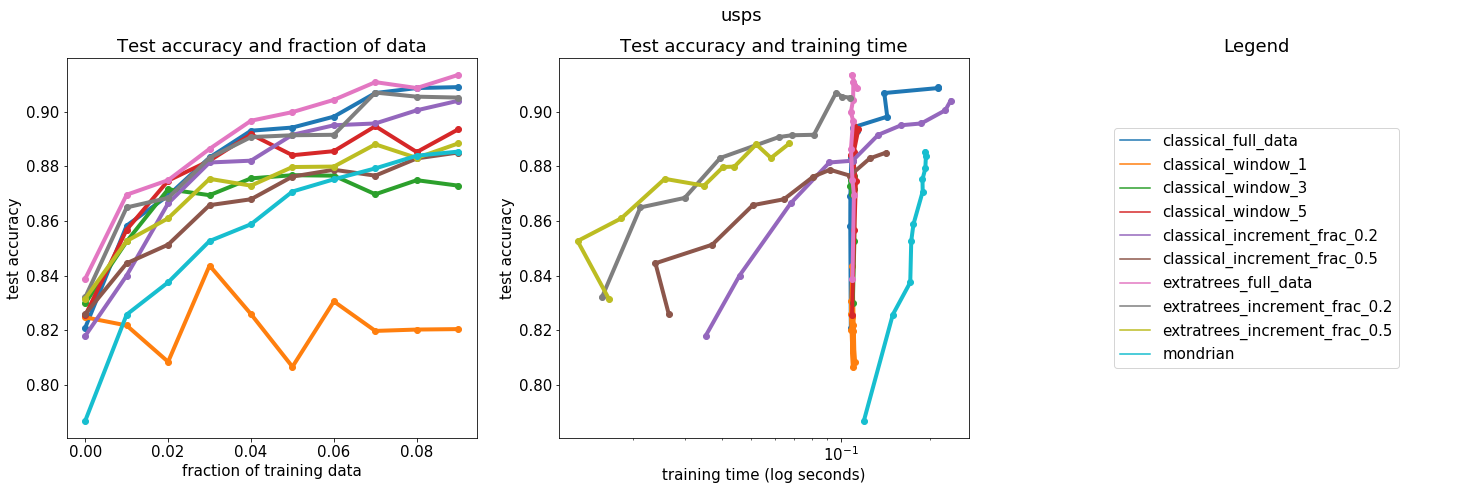

Loading letter...
X_train.shape:	 (15000, 16)
y_train.shape:	 (15000,)
X_test.shape:	 (5000, 16)
y_test.shape:	 (5000,)
Running on letter...
	classical_full_data


/Users/maria/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


	classical_window_1
	classical_window_3
	classical_window_5
	classical_increment_frac_0.2
	classical_increment_frac_0.5
	extratrees_full_data
	extratrees_increment_frac_0.2
	extratrees_increment_frac_0.5
	mondrian


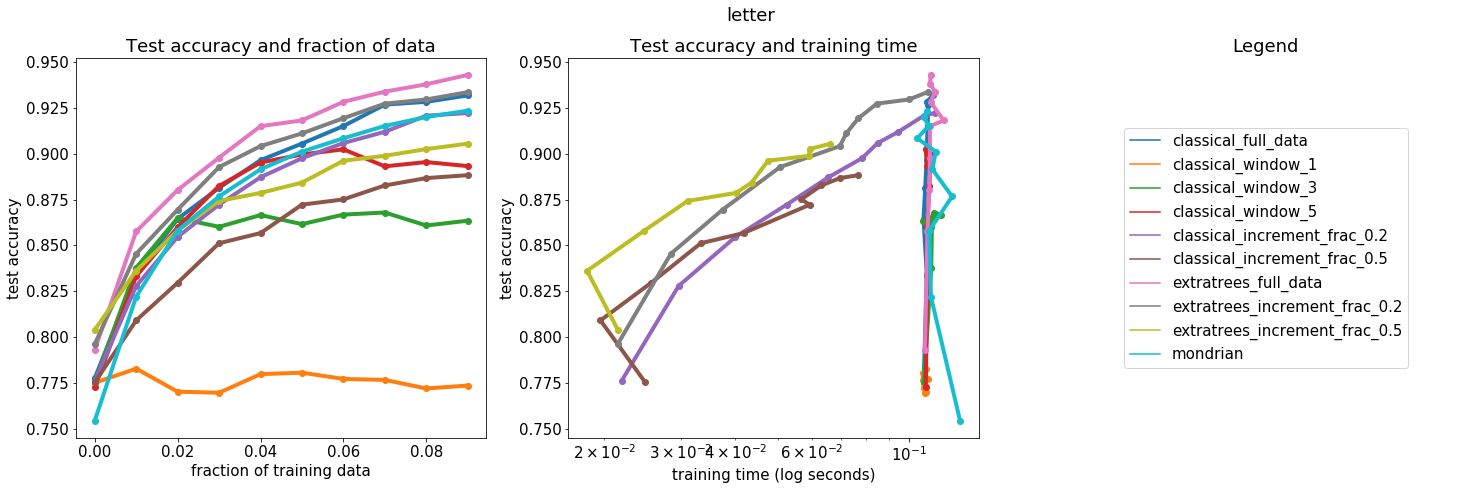

Loading satim...
X_train.shape:	 (4435, 36)
y_train.shape:	 (4435,)
X_test.shape:	 (2000, 36)
y_test.shape:	 (2000,)
Running on satim...
	classical_full_data


/Users/maria/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


	classical_window_1
	classical_window_3
	classical_window_5
	extratrees_full_data
	mondrian


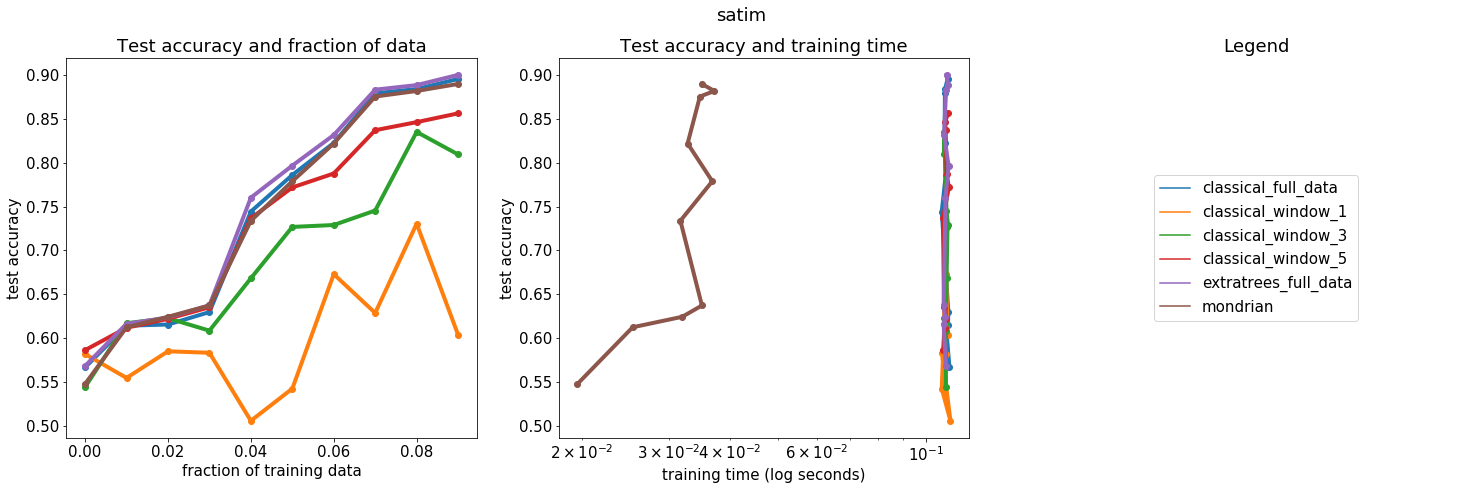

Loading dna...
X_train.shape:	 (1400, 180)
y_train.shape:	 (1400,)
X_test.shape:	 (1186, 180)
y_test.shape:	 (1186,)
Running on dna...
	classical_full_data
	classical_window_1
	classical_window_3
	classical_window_5
	classical_increment_frac_0.2
	classical_increment_frac_0.5
	extratrees_full_data
	extratrees_increment_frac_0.2
	extratrees_increment_frac_0.5
	mondrian


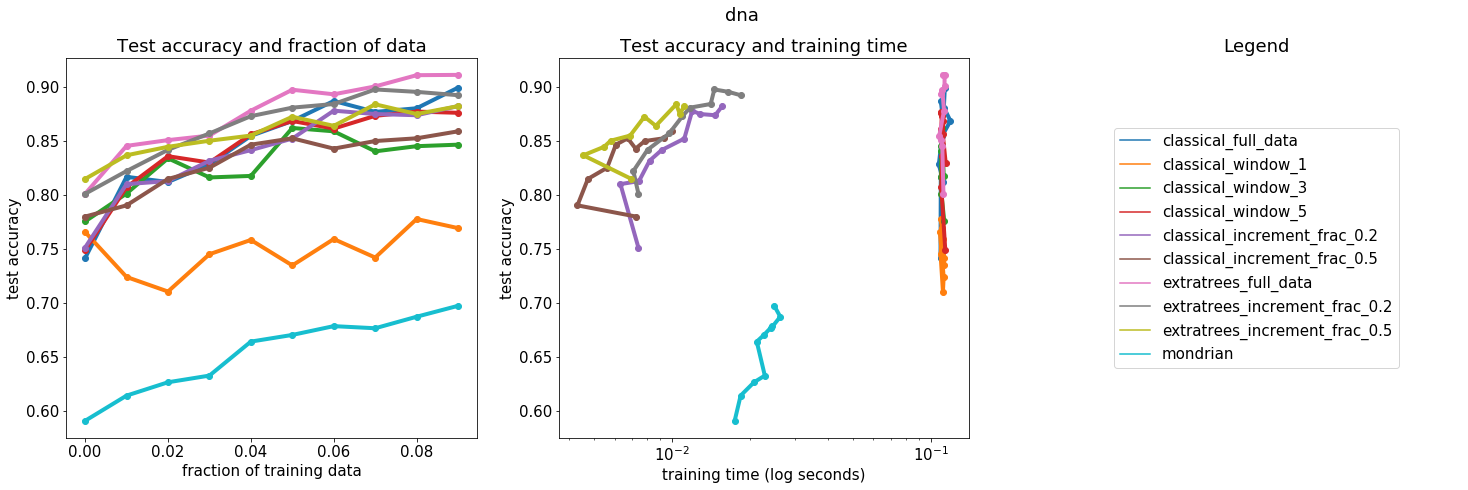

CPU times: user 1min 43s, sys: 9.28 s, total: 1min 53s
Wall time: 4min 5s


In [17]:
%%time

n_batches = 10
n_estimators = 10
max_depth = None
n_iter = 5

run_all_methods_all_datasets(n_iter, n_batches, n_estimators, max_depth)

Loading usps...
X_train.shape:	 (7291, 256)
y_train.shape:	 (7291,)
X_test.shape:	 (2007, 256)
y_test.shape:	 (2007,)
Running on usps...
	classical_full_data
	classical_window_1
	classical_window_3
	classical_window_5
	classical_increment_frac_0.2
	classical_increment_frac_0.5
	extratrees_full_data
	extratrees_increment_frac_0.2
	extratrees_increment_frac_0.5
	mondrian


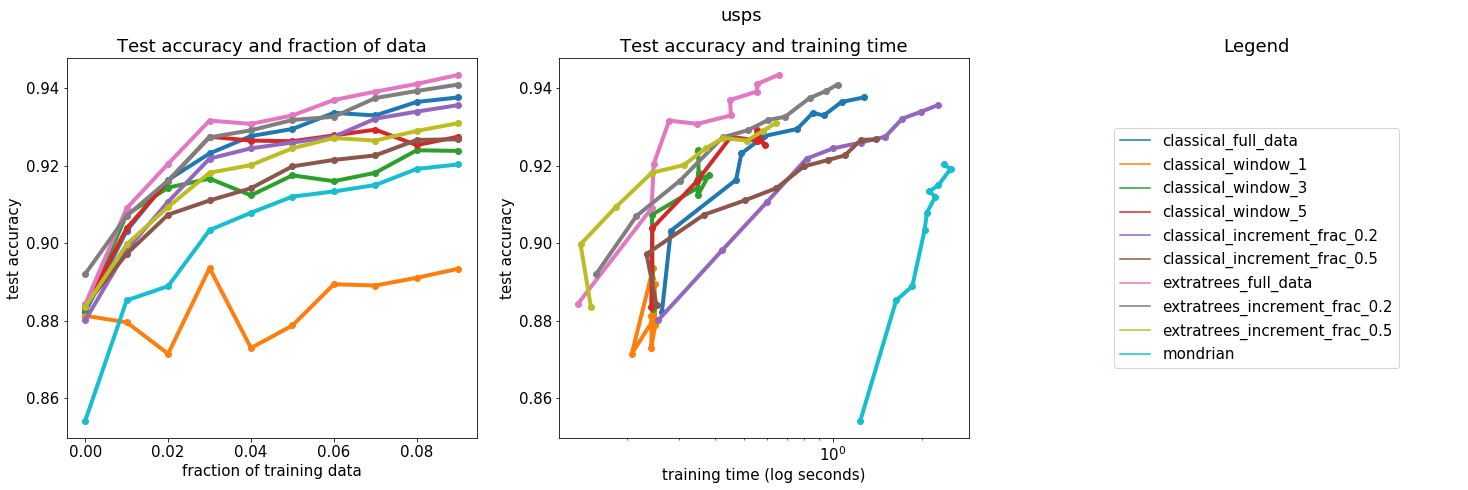

Loading letter...
X_train.shape:	 (15000, 16)
y_train.shape:	 (15000,)
X_test.shape:	 (5000, 16)
y_test.shape:	 (5000,)
Running on letter...


/Users/maria/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


	classical_full_data
	classical_window_1
	classical_window_3
	classical_window_5
	classical_increment_frac_0.2
	classical_increment_frac_0.5
	extratrees_full_data
	extratrees_increment_frac_0.2
	extratrees_increment_frac_0.5
	mondrian


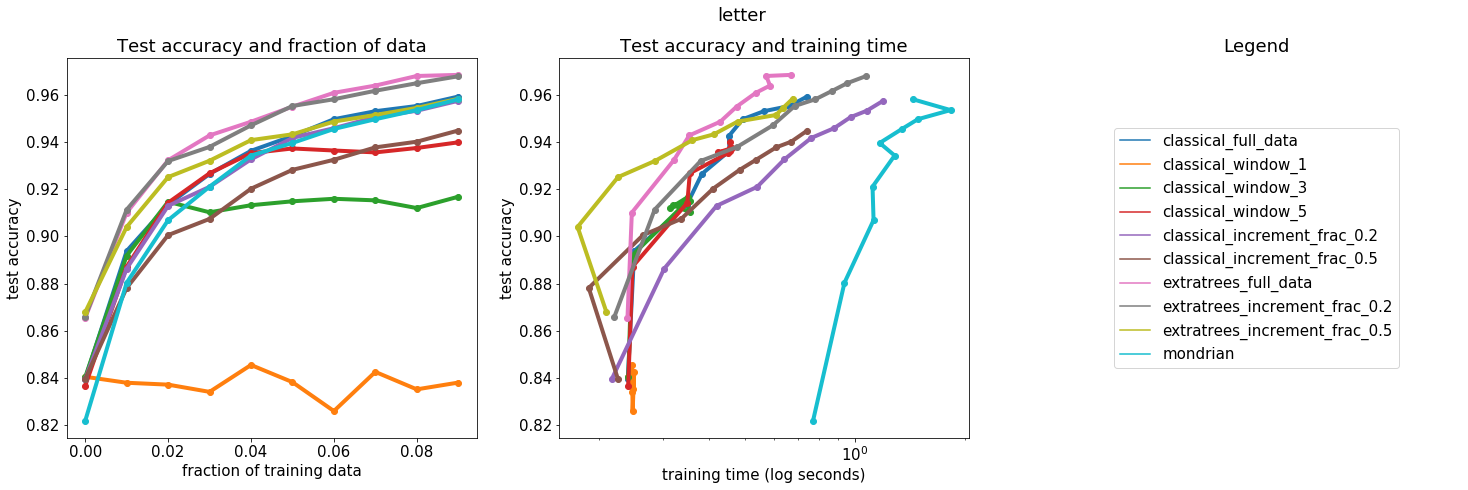

Loading satim...
X_train.shape:	 (4435, 36)
y_train.shape:	 (4435,)
X_test.shape:	 (2000, 36)
y_test.shape:	 (2000,)
Running on satim...
	classical_full_data


/Users/maria/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


	classical_window_1
	classical_window_3
	classical_window_5
	extratrees_full_data
	mondrian


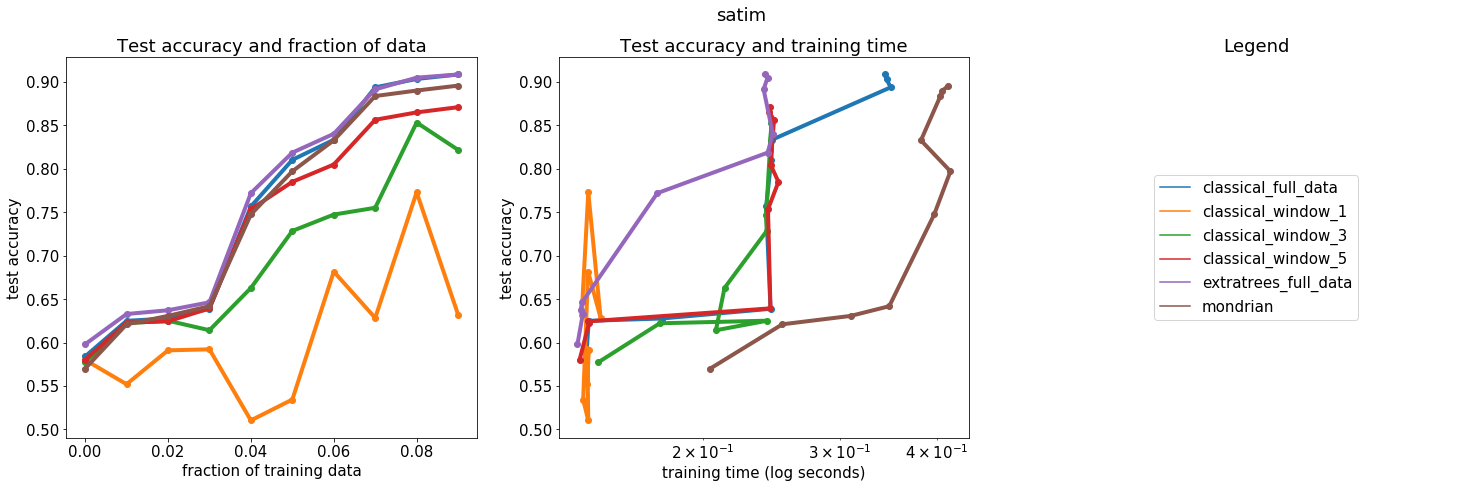

Loading dna...
X_train.shape:	 (1400, 180)
y_train.shape:	 (1400,)
X_test.shape:	 (1186, 180)
y_test.shape:	 (1186,)
Running on dna...
	classical_full_data
	classical_window_1
	classical_window_3
	classical_window_5
	classical_increment_frac_0.2
	classical_increment_frac_0.5
	extratrees_full_data
	extratrees_increment_frac_0.2
	extratrees_increment_frac_0.5
	mondrian


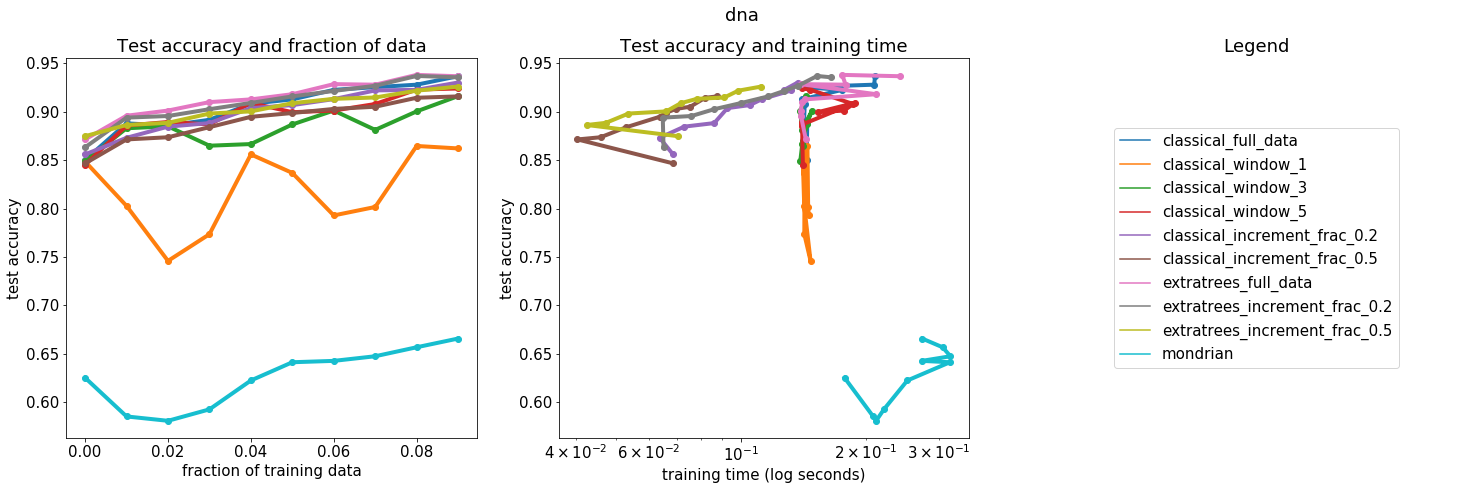

CPU times: user 15min 4s, sys: 1min 18s, total: 16min 23s
Wall time: 13min 9s


In [20]:
%%time

n_batches = 10
n_estimators = 100
max_depth = 50
n_iter = 5

run_all_methods_all_datasets(n_iter, n_batches, n_estimators, max_depth)